***ULTIMATE DATA SCIENCE CHALLENGE***

***1. Exploratory Data Analysis***

In [1]:
### Loading Libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
### 1.) Loading the Data

path = '/Users/elliotgaynon/Desktop/Springboard/ultimate_challenge/data/logins.json'

df = pd.read_json(path)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


***Inspection of DataFrame***

In [3]:
### check number of rows

df.shape

(93142, 1)

We have 93142 rows and 1 column

In [4]:
### check column names
df.columns

Index(['login_time'], dtype='object')

Need to convert from 'object' to 'datetime'

In [5]:
### 2. Convert to Datetime object
df['login_time'] = pd.to_datetime(df['login_time'])
df = df.sort_values('login_time')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93142 entries, 6 to 93140
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


We have 9,3142 columns of datetime objects. No missing objects

***Data Aggregation***

In [7]:
### - Aggregate into 15 minute intervals

logins_15min = (
    df
    .set_index('login_time')
    .resample('15T')
    .size()
    .reset_index(name='login_count')
)

/var/folders/8_/gv8z_wls7k381qn165ygj3jh0000gn/T/ipykernel_5310/2762378568.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('15T')


In [8]:
logins_15min

,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


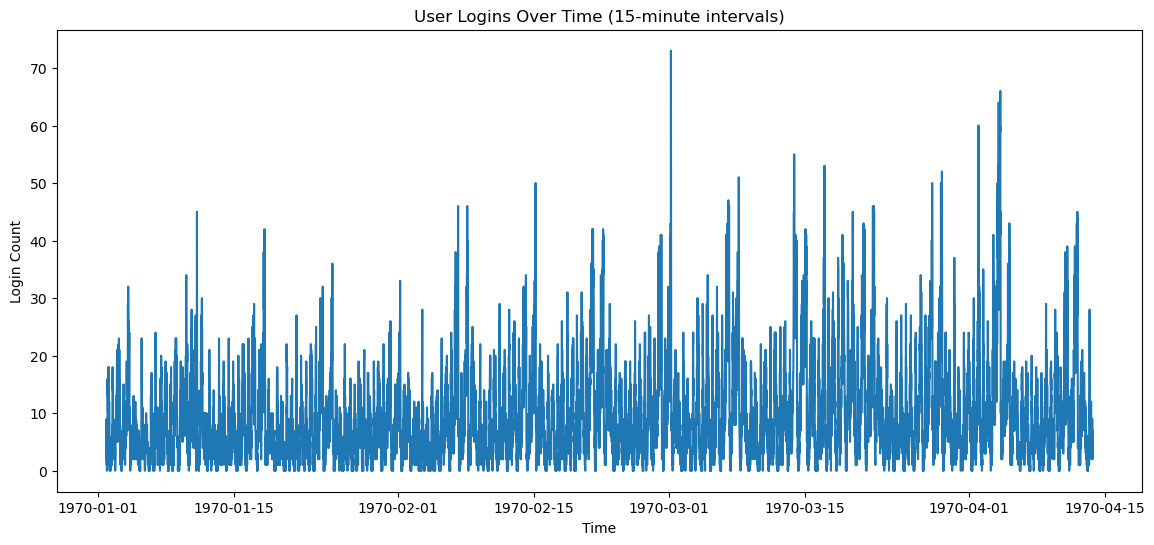

In [9]:
### Vizualize the time series

plt.figure(figsize=(14,6))
plt.plot(logins_15min['login_time'], logins_15min['login_count'])
plt.title("User Logins Over Time (15-minute intervals)")
plt.xlabel("Time")
plt.ylabel("Login Count")
plt.show()

From this plot one can see the spikes, trends and daily patterns. Now to dig deeper...

***Key Analyses***

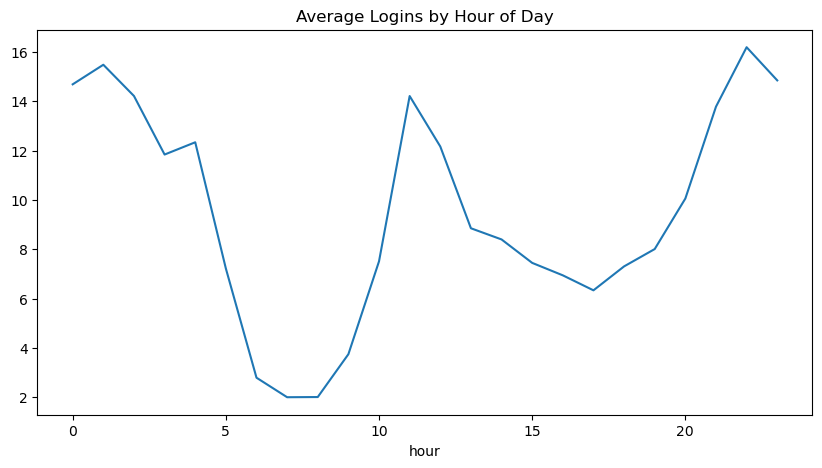

In [10]:
### Daily Patterns - Average Logins by time of day

logins_15min['time_of_day'] = logins_15min['login_time'].dt.time
logins_15min['hour'] = logins_15min['login_time'].dt.hour

avg_by_hour = logins_15min.groupby('hour')['login_count'].mean()

avg_by_hour.plot(kind='line', figsize=(10,5), title="Average Logins by Hour of Day")
plt.show()

The analysis of login activity by hour of day reveals several clear patterns in user demand.

Login activity shows noticeable spikes at approximately 1:00, 11:00, and 21:00, indicating peak periods of platform usage. These peaks suggest that users are most active during late night, late morning, and evening hours.

In contrast, the quietest periods occur between 6:00 and 8:00, where login activity reaches its lowest levels. This likely reflects early morning hours when user engagement is minimal.

Additionally, the data shows a strong upward trend from 9:00 to 11:00, suggesting a rapid increase in user activity during the late morning. Another noticeable increase occurs between 22:00 and 23:00, indicating a surge in demand late at night.

Overall, these patterns highlight a clear daily usage cycle, where demand builds throughout the day, peaks at specific times, and drops during early morning hours.

In [11]:
### Weekly Patterns - Average Logins per day

logins_15min['day_of_week'] = logins_15min['login_time'].dt.day_name()

avg_by_day = logins_15min.groupby('day_of_week')['login_count'].mean()

avg_by_day.sort_values()

day_of_week
Monday        6.213380
Tuesday       6.895833
Wednesday     7.692708
Thursday      8.794118
Friday       10.561111
Sunday       12.615972
Saturday     13.456250
Name: login_count, dtype: float64

Analysis of login activity by day of the week shows clear differences between weekdays and weekends.
Login volume is highest on weekends, indicating that user activity increases significantly during this period.

In contrast, the lowest number of logins occurs early in the week, particularly on Monday and Tuesday. This suggests that user engagement is lower at the beginning of the workweek.

Overall, the results indicate a weekend-driven usage pattern, where demand builds toward the end of the week and peaks during Saturday and Sunday before declining again at the start of the week.

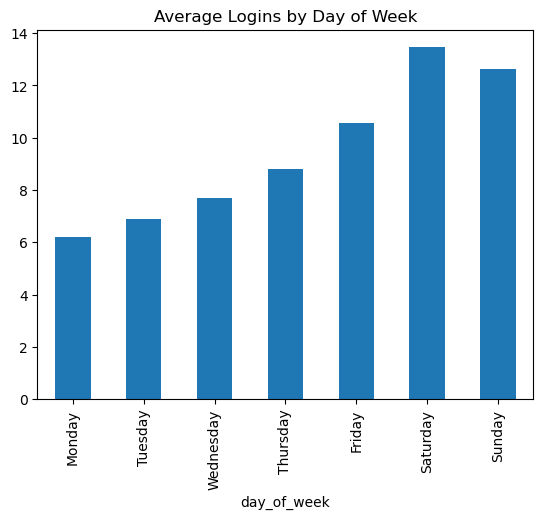

In [12]:
### Plot Weekly

avg_by_day = avg_by_day.reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
])

avg_by_day.plot(kind='bar', title="Average Logins by Day of Week")
plt.show()

The visualization confirms that weekends are busier than weekdays.

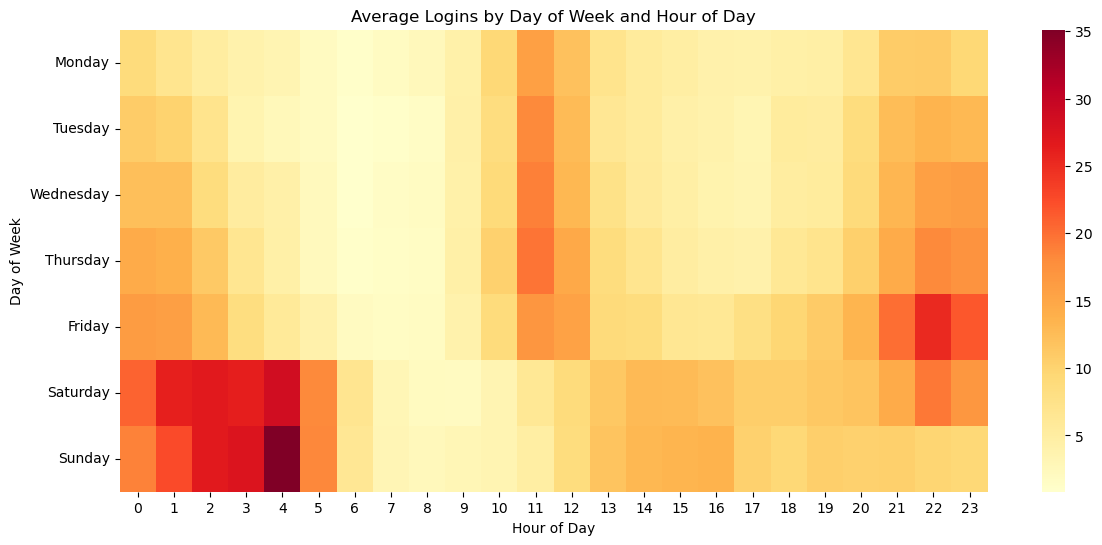

In [13]:
### Heatmap 

pivot = logins_15min.pivot_table(
    values='login_count',
    index=logins_15min['login_time'].dt.day_name(),
    columns=logins_15min['login_time'].dt.hour,
    aggfunc='mean'
)

# Order the days properly
pivot = pivot.reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
])

plt.figure(figsize=(14,6))
sns.heatmap(pivot, annot=False, cmap='YlOrRd')
plt.title("Average Logins by Day of Week and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

The heatmap reveals that the highest login activity occurs on weekends, particularly on Saturday and Sunday between the hours of 1:00 and 2:00. These time periods appear as the darkest (reddest) areas in the visualization, indicating peak demand.

This pattern suggests that user engagement is especially high during late-night hours on weekends, which may reflect increased leisure time and social activity during those periods.

In contrast, most weekdays show lighter colors during early morning hours, indicating lower login activity. Overall, the heatmap confirms both a weekly cycle, where weekends experience more activity, and a daily cycle, where demand peaks late at night.

These findings suggest that system demand is likely to be highest during weekend late-night hours, which could be important for capacity planning, staffing, or targeted promotions during peak engagement periods.

***Data Quality checks***

In [14]:
### Missing Time Intervals

logins_15min['login_count'].isna().sum()

np.int64(0)

Zero time intervals are missing.

In [15]:
### Gaps in time

logins_15min['login_time'].diff().value_counts()

login_time
0 days 00:15:00    9787
Name: count, dtype: int64

Every timestamp is 15 minutes apart.  There are no missing time intervals.  Thus, time series is consistent and complete.

In [16]:
### Outliers

logins_15min['login_count'].describe()

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: login_count, dtype: float64

A median (7) lower than the mean (9.5) suggets a right-skew.  Thus there are potential spikes in activity.  The highest log-in count is 73.  This may be due to peak activity. Not necessarily an outlier.  A minimum of zero logins is totally reasonable ,as no one may have "logged in" during this period of time.

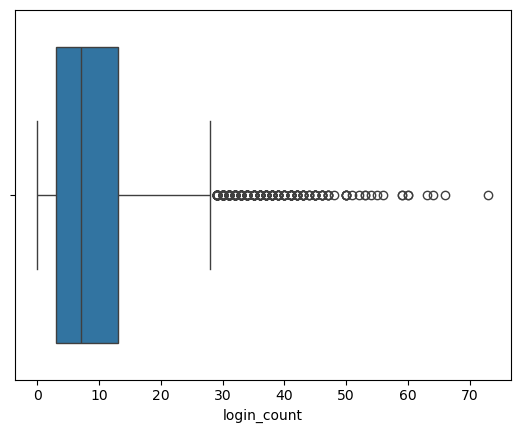

In [17]:
### - Plotting the potential outliers

sns.boxplot(x=logins_15min['login_count'])
plt.show()

The boxplot flags many of the higher login counts as outliers due to the right-skewed distribution. 
These points correspond to legitimate peak demand periods, rather than data errors. 
This is expected in time-series data representing user activity.

***Part 2 - Experiment and metrics design***

****Q1: What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?****

****A1:**** The main goal is to encourage drivers to serve both cities, so the key metric should capture multi-city activity.  Thus the metric will be which fraction of driver partners are active in both cities each week.  This will measure whether or not drivers cross the roll bridge and serve both cities.  As such, it directly captures the behavior the activity intends to change. 

****Q2: Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:****

****a) how you will implement the experiment****

I will design an A/B test at the driver level.  All drivers will serve both cities.  Whether or not the driver is a part of the control or treatment group will be selected at random.  The drivers who pay tolls when they cross the bridge will be the control group.  The treatment group will be drivers who are reimbursed toll fees.

The duration of the experiment will be 1 month.  This will give enough time to capture not only daily trends, but weekly trends. 

Data will be collected by tracking the number of drivers working in both cities, trips completed in each city, and any side effects (such as driver satisfaction or idle time).

Lastly, it must be ensured that the same drivers are tracked throughout the experiment AND activity will be tracked before and after intervention to establish a baseline and assess any differences that arise.

****b) what statistical test(s) will you conduct to verify the significance of the observation****

A chi-squared test will be used to assess the proportion of drivers who work in both cities is different between the treatment and the control.  The null hypothesis is the reimbursement has no effect and the proportions are the same between treatment group and control group.  The alternative hypothesis is the treatment increases the proportion of drivers active in both cities.  The alpha will be 0.005.  If the p-value is below 0.05, we can reject the null hypothesis and conclude the effect is significant.

****c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.****

There are two possible results that may be observed.  In scenario one, the fraction of drivers is significantly higher in the treatment vs the control group. In this scenario it would be recommended that the business implement toll reimbursement permenantly in order to increase cross-city coverage on the whole.  The other scenario would show no significant effect.  In this outcome, the intervention should be reconsidered as maybe the toll is not the main barrier to cross-city work.

The following should be considered as caveats.  Seasonal or time-of-day effects may confound results, as weekday or weeknight patterns differ.  Also the metric is only capturing short-term behavior.  Long-term behavior may differ.  Additionally, randomization must be adhered to.  Drivers should at no time be allowed to self-select themselves into the treatment group.

*****Part 3 - Predictive Modeling*****

In this exercise, I would like to predict whether or not a rider has been retained.  According to the instructions, a rider has been retained if '...they were "active" (i.e. took a trip) in the preceding 30 days.'  This will be a supervised classification problem.  Once the best model is selected, the most important features will be explored and from that business recommendations will follow.

In [18]:
### 1.) Loading the Data

ultimate_challenge = '/Users/elliotgaynon/Desktop/Springboard/ultimate_challenge/data/ultimate_data_challenge.json'

df = pd.read_json(ultimate_challenge)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


Successfully loaded the DataFrame.  Now I'd like to see a quick overview of the data.

In [19]:
# Quick overview - Understanding dtypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Our sample size is 50,000.  Avg_rating_of_driver is 41,878. It is missing 8,022 rows.  Phone is 49,604.  It's missing 396 rows. Avg_rating_by_driver is missing 201 rows.

Signup_date and last_trip_date are 'objects.'  Need to convert them into datetime objects.  

Also 'city' and 'phone' are objects. I will convert them into categories.

In [20]:
# Convert dates to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y-%m-%d')
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], format='%Y-%m-%d')

In [21]:
# Convert city and phone to 'category'
df['city'] = df['city'].astype('category')
df['phone'] = df['phone'].astype('category')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  category      
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  category      
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), category(2), datetime64[ns](2), fl

Columns converted to datetime!

***Missing values***

Because phone number is only a small number missing (less than 1 percent), I will drop these. 

For Avg_rating_of_driver and Avg_rating_by_driver I will impute by median.  With ratings, the mean can be pulled up or down by extreme values while the median represents the typical user more robustly.

In [23]:
### - Drop missing phone phone rows

df = df.dropna(subset=['phone'])

In [24]:
### - confirm Missing Phone values dropped

df['phone'].isna().sum()

np.int64(0)

In [25]:
df.shape

(49604, 12)

In [26]:
### - Impute missing rating values with median

df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median(), inplace=True)

/var/folders/8_/gv8z_wls7k381qn165ygj3jh0000gn/T/ipykernel_5310/2720180086.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median(), inplace=True)
/var/folders/8_/gv8z_wls7k381qn165ygj3jh0000gn/T/ipykernel_5310/2720180086.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

In [27]:
### - confirm no missing values

df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

***Cutoff Date for Retention label***

We define a user as retained if they took a tirp in the 30 days before the dataset was pulled.

In [28]:
max_date = df['last_trip_date'].max()
min_date = df['last_trip_date'].min()

print(min_date, max_date)

2014-01-01 00:00:00 2014-07-01 00:00:00


The latest  'last_trip_date' was July 1st, 2014 (2014-07-01).  So if data was pulled 07-01-2014, we set the cutoff date for 30 days prior (2014-06-01). This is the day our retention window starts.

In [29]:
### - Create the retension Window
cutoff_date = df['last_trip_date'].max()

df['retained'] = (df['last_trip_date'] >= cutoff_date - pd.Timedelta(days=30)).astype(int)

Retention was defined as whether a user took at least one trip in the 30 days preceding the dataset extraction date. The latest trip date in the dataset is July 1, 2014, so users with trips on or after June 1, 2014 were labeled as retained.

In [30]:
### - Verify Target variable

df['retained'].value_counts()

retained
0    30933
1    18671
Name: count, dtype: int64

During the retension window, it appears less customers were retained.

In [31]:
### - Percentage of class imbalence

df['retained'].value_counts(normalize=True)

retained
0    0.623599
1    0.376401
Name: proportion, dtype: float64

62.4 percent of customers were not retained.  Whereas 37.6 percent of customers were retained. This means that retention is moderately imbalanced, but not extreme.  This should be kept in mind as I model and assess results.

***Exploratory Data Analysis***

In [32]:
### - General Stastical Overview
df.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,49604.000000,49604,49604.00000,49604.000000,49604,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,2.277256,2014-01-16 13:02:24.859285760,4.64977,1.074991,2014-04-19 11:13:41.836948480,8.875314,60.883832,5.785418,4.778748,0.376401
min,0.000000,2014-01-01 00:00:00,1.00000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,2014-01-09 00:00:00,4.50000,1.000000,2014-02-14 18:00:00,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,2014-01-17 00:00:00,4.90000,1.000000,2014-05-08 00:00:00,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,2014-01-24 00:00:00,5.00000,1.050000,2014-06-18 00:00:00,8.700000,100.000000,6.930000,5.000000,1.000000
max,125.000000,2014-01-31 00:00:00,5.00000,8.000000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000,1.000000
std,3.793300,NaN,0.57582,0.222666,NaN,19.989018,37.086239,5.669709,0.446440,0.484487


***1. Univariate Analysis*** - I wish to understand the overall Retention rate

In [33]:
### - Percentages

df['retained'].value_counts()
df['retained'].value_counts(normalize=True)

retained
0    0.623599
1    0.376401
Name: proportion, dtype: float64

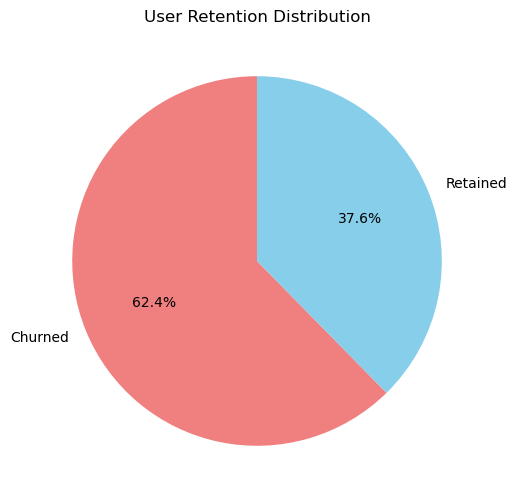

In [34]:
### - Visualization

retention_counts = df['retained'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    retention_counts,
    labels=['Churned', 'Retained'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightcoral', 'skyblue']
)
plt.title('User Retention Distribution')
plt.show()

A pie chart was used to visualize the distribution of the retention target variable. Approximately 38% of users were retained, while 62% of users churned, indicating that a majority of users did not remain active. This highlights the importance of identifying factors that drive long-term engagement.

***2. Bivariate Analysis*** - Target vs Features

***A. Categorical Features vs Retention***

The categorical features of this dataset are 'city', 'phone', and 'ultimate_black_user'.

In [35]:
### - Retension rate by category

city_retained = df.groupby('city')['retained'].mean().sort_values(ascending=False)
phone_retained = df.groupby('phone')['retained'].mean()
ubu_retained = df.groupby('ultimate_black_user')['retained'].mean()

print(city_retained)
print(phone_retained)
print(ubu_retained)

city
King's Landing    0.628353
Winterfell        0.352346
Astapor           0.255773
Name: retained, dtype: float64
phone
Android    0.209426
iPhone     0.448933
Name: retained, dtype: float64
ultimate_black_user
False    0.298819
True     0.505588
Name: retained, dtype: float64


/var/folders/8_/gv8z_wls7k381qn165ygj3jh0000gn/T/ipykernel_5310/3304400887.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_retained = df.groupby('city')['retained'].mean().sort_values(ascending=False)
/var/folders/8_/gv8z_wls7k381qn165ygj3jh0000gn/T/ipykernel_5310/3304400887.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phone_retained = df.groupby('phone')['retained'].mean()


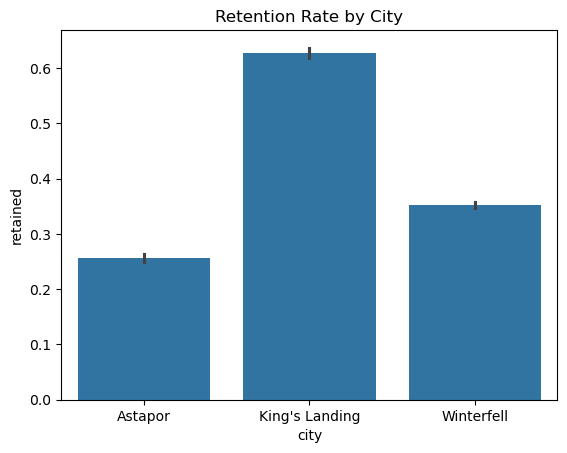

In [36]:
### - Visualizations
### - City

sns.barplot(data=df, x='city', y='retained')
plt.title("Retention Rate by City")
plt.show()


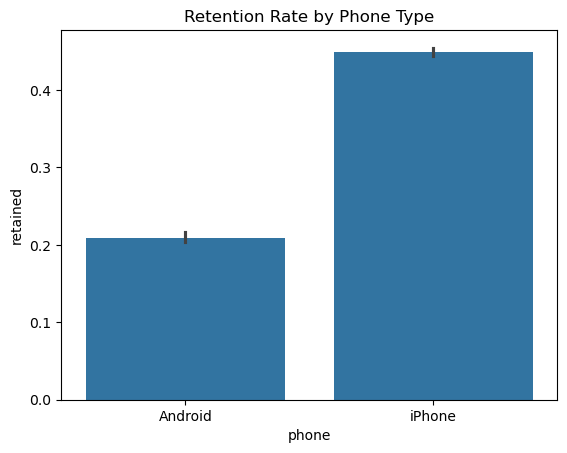

In [37]:
### - Visualizations
### - Phone Type

sns.barplot(data=df, x='phone', y='retained')
plt.title("Retention Rate by Phone Type")
plt.show()

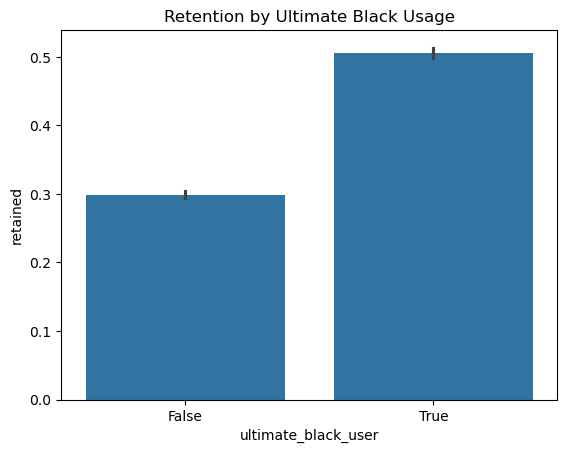

In [38]:
### - Visualization 
### - Ultimate Black User

sns.barplot(data=df, x='ultimate_black_user', y='retained')
plt.title("Retention by Ultimate Black Usage")
plt.show()

Retention varies across several categorical features. Kings Landing users exhibit the highest retention rates among the cities. iPhone users retain at higher rates than Android users, suggesting potential differences in engagement by device type. Additionally, users who tried Ultimate Black within their first 30 days show significantly higher retention, indicating that early exposure to premium services may encourage continued platform usage.  These results suggest htat encourage early engagement with premium services and understanding platform differences across cities and devices could help improve overall retention.

***B. Numerical Features vs Retention.***

In [39]:
### - Compare the means of numerical features vs retention.

df.groupby('retained')[[
    'trips_in_first_30_days',
    'avg_dist',
    'avg_rating_by_driver',
    'avg_rating_of_driver',
    'surge_pct',
    'avg_surge',
    'weekday_pct'
]].mean()

,trips_in_first_30_days,avg_dist,avg_rating_by_driver,avg_rating_of_driver,surge_pct,avg_surge,weekday_pct
retained,,,,,,,
0,1.657033,6.190725,4.788152,4.667918,8.700091,1.075689,60.605952
1,3.304804,5.113930,4.763167,4.619704,9.165615,1.073834,61.344208


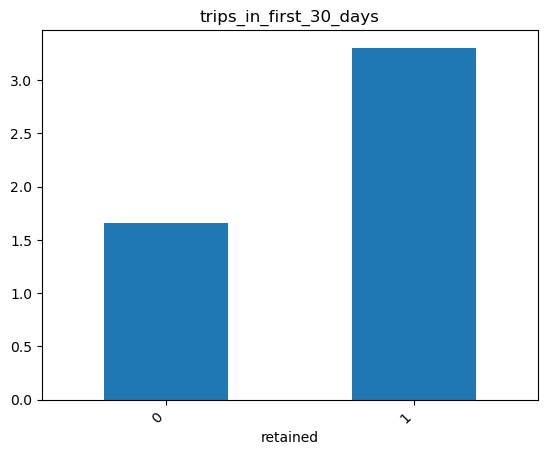

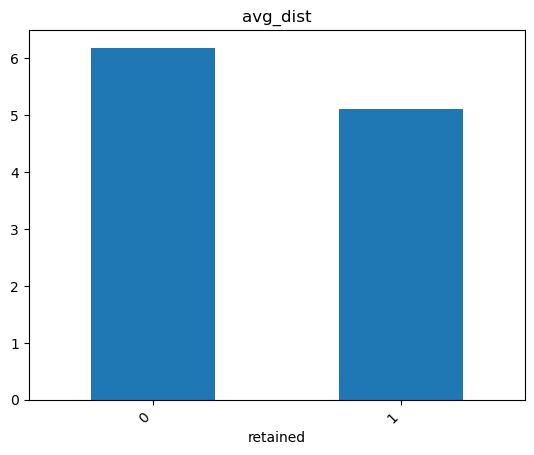

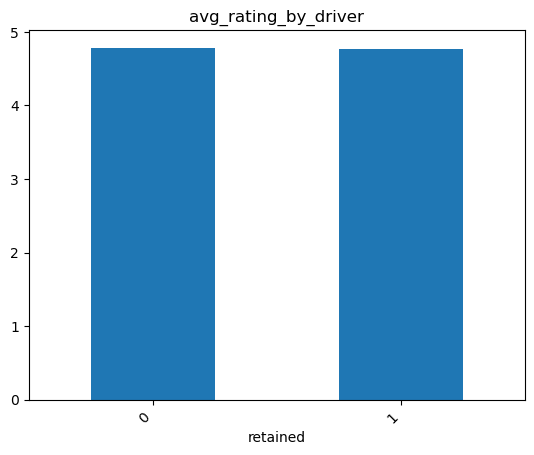

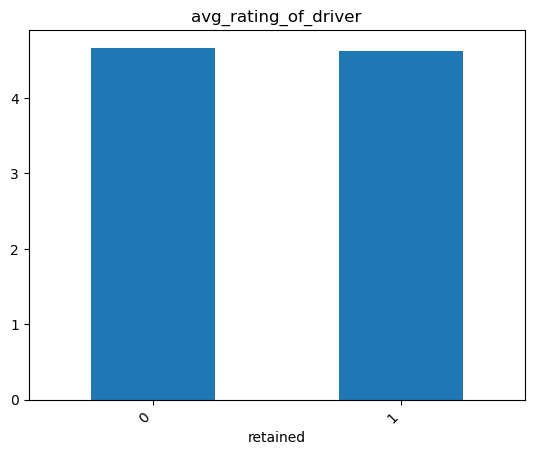

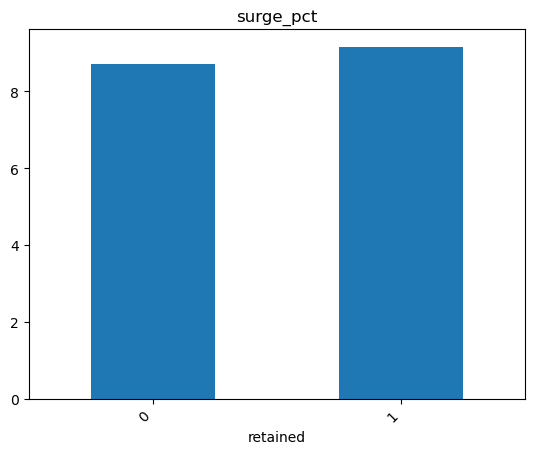

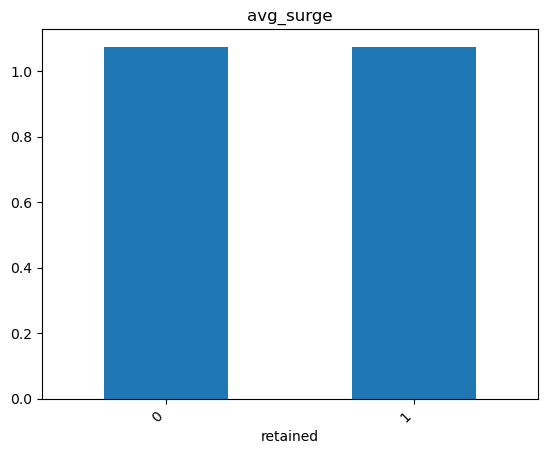

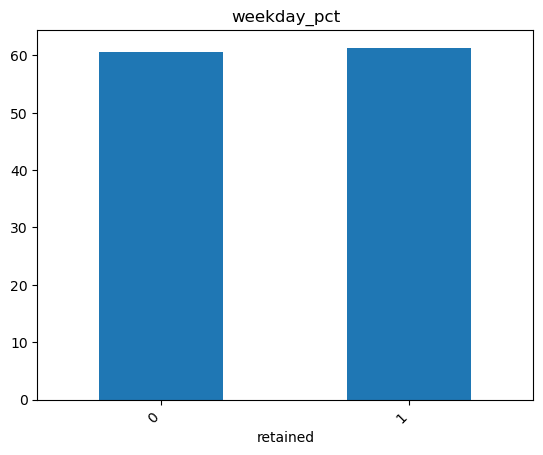

In [51]:
### - Visualization of Numerical features vs retention

num_cols = [
    'trips_in_first_30_days',
    'avg_dist',
    'avg_rating_by_driver',
    'avg_rating_of_driver',
    'surge_pct',
    'avg_surge',
    'weekday_pct'
]

for col in num_cols:
    df.groupby('retained')[col].mean().plot(kind='bar')
    plt.xticks(rotation=45, ha='right')
    plt.title(col)
    plt.show()

From the above chart and histograms, one can glean several insights..  One key finding is that early engagement is the strongest predictor of retention.  On average ,those who took were retained took 3.30 trips within the first 30 days compared to the 1.66 trips of those who did not.

Average trip distance was also an interesting predictor.  Retained users tend to take slightly shorter trips on average, which may indicate more frequent routine usage such as the daily commute.  

Ratings appear very similar, so I will assume ratings do not strongly differentiate retained and churned users.  Surge pricing and weekday usage also had very small differences.

In conclusion, early engagement is the strongest predictor of retention.

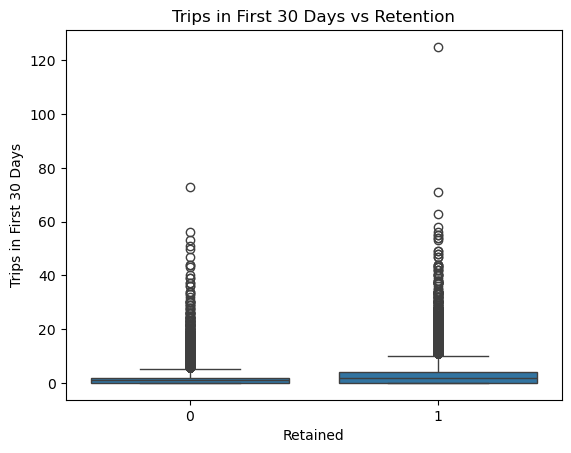

In [52]:
### - Visualize Early Engagement vs Retention

sns.boxplot(data=df, x='retained', y='trips_in_first_30_days')
plt.title("Trips in First 30 Days vs Retention")
plt.xlabel("Retained")
plt.ylabel("Trips in First 30 Days")
plt.show()

From the graph, one can see the median is higher for retained Users.

***3. Association Analysis***

In this section, I wish to quantify feature importance using correlation and modeling.

***A. Correlation with retention***

In [53]:
### - Quantify Numerical Features correlation with Retention

num_cols = [
    'trips_in_first_30_days',
    'avg_dist',
    'avg_rating_by_driver',
    'avg_rating_of_driver',
    'surge_pct',
    'avg_surge',
    'weekday_pct']

corr = df[num_cols + ['retained']].corr()

corr['retained'].sort_values(ascending=False)

retained                  1.000000
trips_in_first_30_days    0.210456
surge_pct                 0.011283
weekday_pct               0.009644
avg_surge                -0.004035
avg_rating_by_driver     -0.027114
avg_rating_of_driver     -0.040566
avg_dist                 -0.092014
Name: retained, dtype: float64

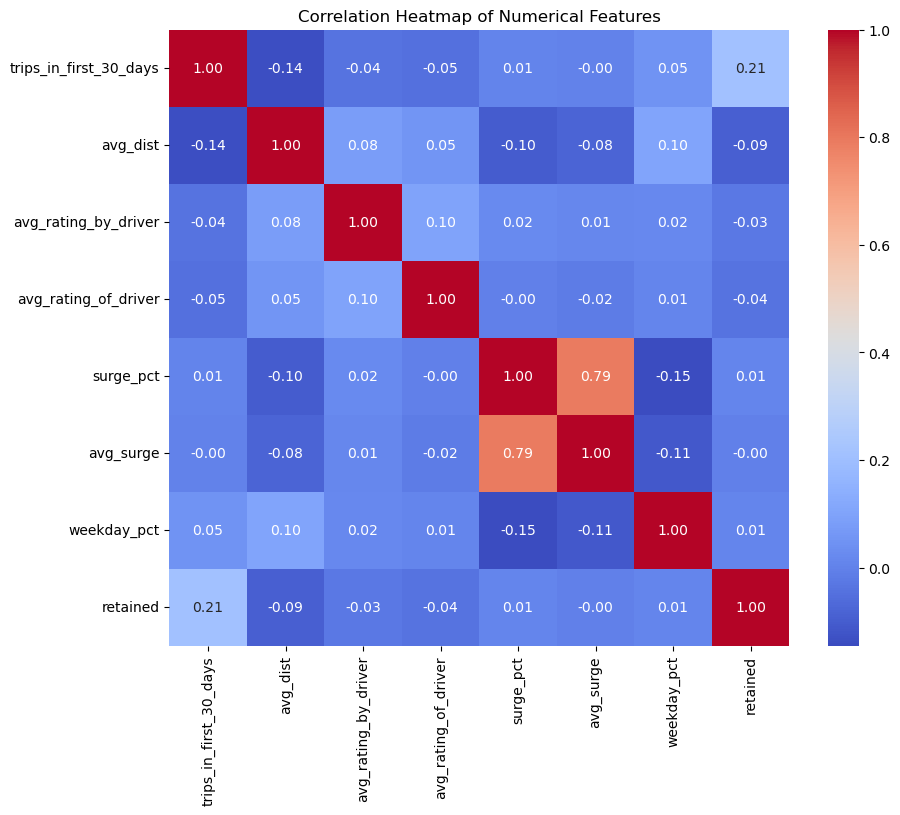

In [57]:
### - Numerical Features Heatmap

num_cols_heat = [
    'trips_in_first_30_days',
    'avg_dist',
    'avg_rating_by_driver',
    'avg_rating_of_driver',
    'surge_pct',
    'avg_surge',
    'weekday_pct', 'retained']

corr_num_heat = df[num_cols_heat].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_num_heat, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

From the above, one can see that 'trips_in_first_30_days' correlates to retention the most.  This confirms early findings that early engagement is the key driver for retention.  Average distance is weakly correlated.  This suggests users who take shorter trips are slightly more likely to be retained.  

Ratings show a very small negative correlation.  Thus, it can be concluded tht tehy do not meaningfully influence retention in this dataset.

Surge and Weekday usage have almost no correlation.  This suggests that pricing dynamics and trip timing are not strong predictors of long-term engagement.

***B. Cramer's V - Categorical vs Target***

In [54]:
### - import scipy

import scipy.stats as stats

### - Cramers v Function

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2 / n) / (min(k-1, r-1)))


cat_cols = ['city', 'phone', 'ultimate_black_user']

for col in cat_cols:
    print(col, cramers_v(df[col], df['retained']))




city 0.2766624519118471
phone 0.22710431323189276
ultimate_black_user 0.20659560550822534


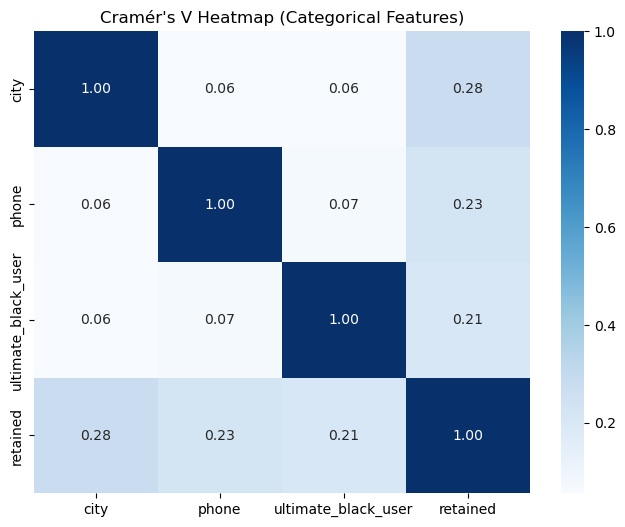

In [60]:
### - Cramer's V Heatmap

cat_cols = ['city', 'phone', 'ultimate_black_user', 'retained']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2 / n) / (min(k-1, r-1)))

cramers_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramers_matrix = cramers_matrix.astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(cramers_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title("Cramér's V Heatmap (Categorical Features)")
plt.show()

All categorical features have moderate relationships with retention.  

City is the strongest categorical predictor.  Thus, retention varies meaningfully by city. This matches what I observed earlier with Kings Landing having a much higher retention than the others.

Phone type also matters.  A Cramer's V of 0.227 confirms that device type is related to retention.  This may be due to user demographics, app performance differences, or platform engagement patters.

Ultimate Black Usage is also important. A Cramer's V of 0.207 shows that users who try premium sevices are more like to stay engaged and thus retention.  If this is offered earlier in in the consumer lifecycle overall retention could be improved.

Overall, categorical featuers are stronger predictors tahn most numerical variables.  However, 'Trips in the First 30 days' remains the strongest predictor.

***5. Non-Linear Analysis***

In [63]:
### Imports

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [64]:
### - One-Hot Encode categorical features

X = pd.get_dummies(
    df[
        ['city', 'phone', 'ultimate_black_user',
         'trips_in_first_30_days', 'avg_dist',
         'avg_rating_by_driver', 'avg_rating_of_driver',
         'surge_pct', 'avg_surge', 'weekday_pct']
    ],
    drop_first=True
)
y = df['retained']

In [66]:
### - Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [67]:
### - Create the model

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42)

In [68]:
### - Train the model

rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [69]:
### - Extract Feature Importance

feature_importances = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(feature_importances)

avg_dist                  0.296346
weekday_pct               0.129769
avg_rating_by_driver      0.120578
surge_pct                 0.080821
avg_rating_of_driver      0.079405
trips_in_first_30_days    0.077372
avg_surge                 0.066122
city_King's Landing       0.065134
phone_iPhone              0.037372
ultimate_black_user       0.031390
city_Winterfell           0.015690
dtype: float64


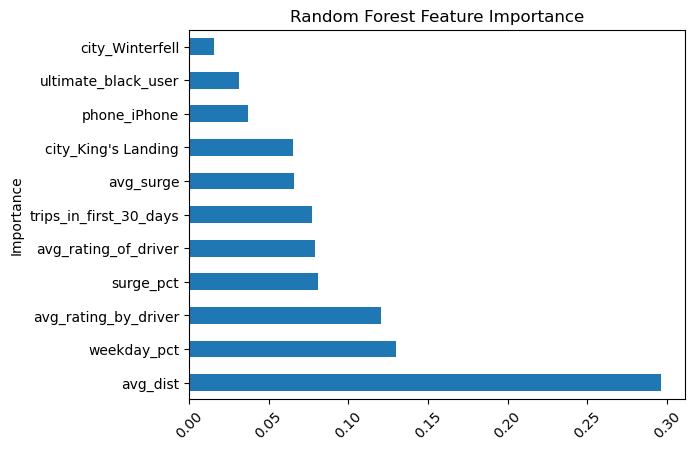

In [71]:
### - Plot the feature importance

feature_importances.plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

Feature importance from a Random Forest model reveals that behavioral variables dominate retention prediction. Average trip distance (0.296) and weekday usage (0.130) are the strongest predictors, followed by ratings by drivers (0.121). Early trips, city, device type, and premium service adoption contribute less strongly. These results suggest that retention is driven more by how and when users engage with the platform rather than demographic or categorical features alone.

***5. Feature Engineering/Pre-Processing***

The target variable is retained.  I want features that capture user behavior, highlight early engagement, reflect platform interaction patterns, and can be used by models - both numerical and categorical.

From the EDA it could be gleaned that early engagement is important for retention.  I will first transform 'first 30 days' to reduce skew.

In [72]:
### - Transform first 30 days to reduce skew

df['log_trips_30'] = np.log1p(df['trips_in_first_30_days'])

In [73]:
### - trips per day, measures average daily engagement

df['trips_per_day_30'] = df['trips_in_first_30_days']/30

Recency Features - how recently someone used the platform is a strong indicator of retention.  I want to capture how many days the user remained active.

In [74]:
### - Recency
df['days_active'] = (df['last_trip_date'] - df['signup_date']).dt.days

Engagement timing features.  Show whether a user is a weekend rider or weekday rider.

In [75]:
df['weekend_pct'] = 100 - df['weekday_pct']

In [76]:
### - Convert ultimate black users to int

df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

In [77]:
### - Log Transform skewed numeric features

df['log_avg_dist'] = np.log1p(df['avg_dist'])
df['log_avg_surge'] = np.log1p(df['avg_surge'])

In [78]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,log_trips_30,trips_per_day_30,days_active,weekend_pct,log_avg_dist,log_avg_surge
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1,1.609438,0.133333,143,53.8,1.541159,0.741937
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0,0.000000,0.000000,96,50.0,2.225704,0.693147
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0,1.386294,0.100000,1,0.0,0.570980,0.693147
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1,2.302585,0.300000,170,20.0,1.211941,0.760806
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0,2.708050,0.466667,47,17.6,1.418277,0.783902


In [79]:
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained', 'log_trips_30', 'trips_per_day_30',
       'days_active', 'weekend_pct', 'log_avg_dist', 'log_avg_surge'],
      dtype='object')

In [80]:
### - Feature Engineering - Get Dummies

features = [
    'log_trips_30','trips_per_day_30','days_active','weekday_pct',
    'weekend_pct','avg_dist','avg_rating_by_driver','avg_rating_of_driver',
    'surge_pct','avg_surge','ultimate_black_user','city','phone'
]

# One-hot encode categorical features
X = pd.get_dummies(df[features], drop_first=True)
y = df['retained']

In [81]:
### - Train - Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [83]:
### - Scaling 

from sklearn.preprocessing import StandardScaler

num_cols = ['log_trips_30','trips_per_day_30','days_active','weekday_pct',
            'weekend_pct','avg_dist','avg_rating_by_driver','avg_rating_of_driver',
            'surge_pct','avg_surge']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test_scaled[num_cols])

***6. Modeling***

In [84]:
### - Training baseline models

### - imports

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [85]:
### - Logistic Regression - baseline

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_log = lr.predict(X_test_scaled)
y_proba_log = lr.predict_proba(X_test_scaled)[:,1]

In [86]:
### - Random Forest - baseline

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

In [87]:
### - Gradient Boosting - baseline

gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:,1]

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      9280
           1       0.94      0.95      0.94      5602

    accuracy                           0.96     14882
   macro avg       0.95      0.96      0.96     14882
weighted avg       0.96      0.96      0.96     14882

ROC-AUC: 0.994


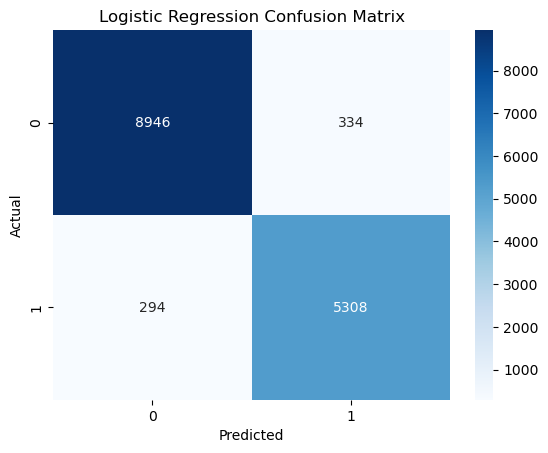

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      9280
           1       0.94      0.95      0.94      5602

    accuracy                           0.96     14882
   macro avg       0.95      0.96      0.96     14882
weighted avg       0.96      0.96      0.96     14882

ROC-AUC: 0.993


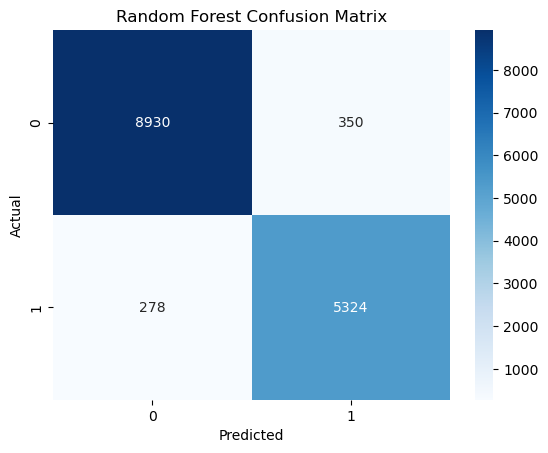

--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9280
           1       0.94      0.95      0.95      5602

    accuracy                           0.96     14882
   macro avg       0.96      0.96      0.96     14882
weighted avg       0.96      0.96      0.96     14882

ROC-AUC: 0.995


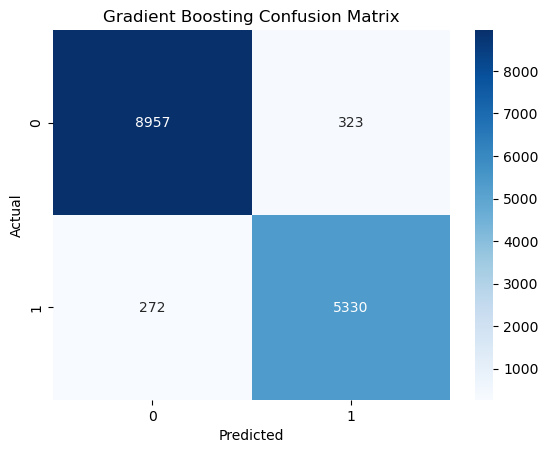

In [88]:
### - Evaluate Models

def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"--- {model_name} ---")
    print(classification_report(y_true, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.3f}")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate all three
evaluate_model(y_test, y_pred_log, y_proba_log, 'Logistic Regression')
evaluate_model(y_test, y_pred_rf, y_proba_rf, 'Random Forest')
evaluate_model(y_test, y_pred_gb, y_proba_gb, 'Gradient Boosting')

All three models performed very well.  However, gradient boosting had the best ROC-AUC score and thus it is the best model for predicting probablity of retention.

I will now assess the feature importance of the gradient boosting model in order to understand which features best drive retention.

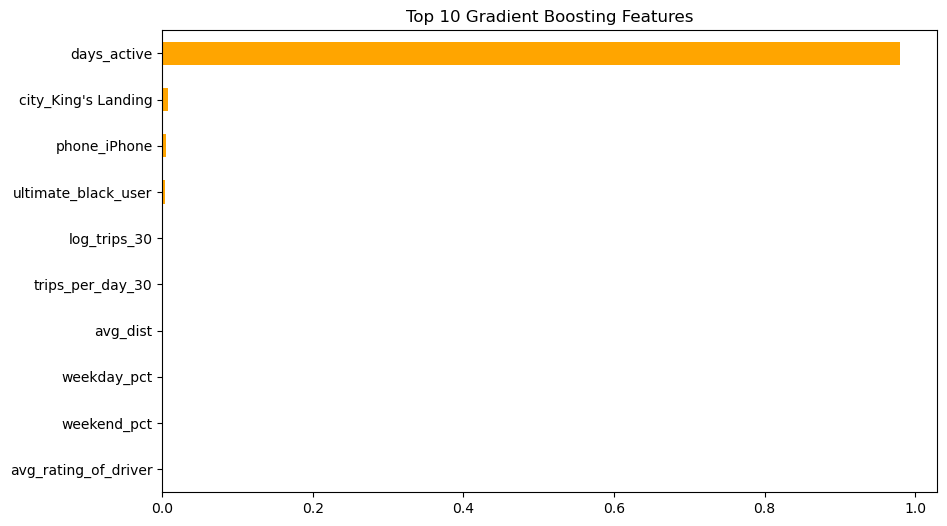

In [89]:
### - Gradient Boosting Feature Importance

gb_importance = pd.Series(gb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
gb_importance.head(10).sort_values().plot(kind='barh', color='orange')
plt.title('Top 10 Gradient Boosting Features')
plt.show()

From the above, we can conclude that engagement dominates retention.  Days_active, log_trips_30, and trips_per_day_30 are all about early activity and consistency.  While city and phone appear important, they are not as important as activity and consistency based features. In other words, behavioral patterns amtter more than demographics.  Premium adoption is also valuable.  Early ultimate_black_user adoption is also a strong signal of retention.  Also seen is how commuting-style behavior also drives retention.

***7. Actionable Recommendations***

Analysis of user behavior shows that early engagement is the strongest predictor of retention. Users who take more trips in their first 30 days, remain active over more days, and adopt Ultimate Black early are significantly more likely to stay active. Weekday trips and longer average distances indicate routine commuting patterns that further enhance retention. City-specific trends reveal that users in King’s Landing retain better, while device type (iPhone vs. Android) also has a modest effect. Positive interactions between riders and drivers, as measured by user ratings, contribute slightly to retention.

To increase user retention, Ultimate should focus on boosting early engagement by offering first-month promotions or incentives, and encouraging the early adoption of Ultimate Black through targeted campaigns. Promoting weekday commuting habits with commuter-focused rewards can help establish routine usage, while tailoring city-level engagement efforts ensures retention is maximized in high-performing regions. Additionally, monitoring and supporting users with low early activity through nudges or reminders, as well as encouraging positive rider-driver interactions, will help maintain long-term engagement across the platform.